with 99 acuracy

In [1]:
import os
import cv2
import numpy as np 
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt 
from random import shuffle , seed
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg19 import VGG19 
from tensorflow.keras.applications   import EfficientNetB3
from tensorflow.keras.applications.densenet import DenseNet201 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input ,concatenate, Dense,Flatten ,Conv2D ,Dropout ,MaxPool2D ,GlobalAveragePooling2D

In [2]:
classes=["WithMask","WithoutMask"]
classes.sort()
print(classes)

['WithMask', 'WithoutMask']


In [3]:
classes={
0:"WithMask",
1:"WithoutMask",

}


#function to get code by name 
def get_code(name):
    for key , value in classes.items():
        if value ==name:
            break
    return key


#function to get name by code
def get_class(key):
    return classes[key]


#test
print("WithMask:", get_code("WithMask"))
print("0 :" ,get_class(0))




WithMask: 0
0 : WithMask


In [4]:
image_size=224

generator=ImageDataGenerator(
       rescale=1./255.0,
      rotation_range=40,
      width_shift_range=0.1,
      height_shift_range=0.1,
vertical_flip=True,
    zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)

batch_size=32                                               
train_generator=generator.flow_from_directory(
    "../input/face-mask-12k-images-dataset/Face Mask Dataset/Train",
    target_size=(image_size, image_size),
    batch_size=32,
    shuffle=True,

)


val_generator=ImageDataGenerator(rescale=1./255.0).flow_from_directory(
    "../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation",
     

    target_size=(image_size, image_size),

    batch_size=32,
    shuffle=True,

)

test_generator=ImageDataGenerator(rescale=1./255.0).flow_from_directory(
    "../input/face-mask-12k-images-dataset/Face Mask Dataset/Test",
     

    target_size=(image_size, image_size),

    batch_size=32,
    shuffle=True,

)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [5]:
#function to show images
def image_show(data, labels , number_of_image ):
    #to generate a random numbers
    numbers=np.random.randint(0,len(data),number_of_image)
    plt.figure(figsize=(30,20))
    j = number_of_image/10
    for _,i in enumerate(numbers):
        plt.subplot(j+1,8,_+1)
        plt.imshow(data[i])
        plt.title(get_class(labels[i])+"\n"+f"size {data[i].shape}")
        #to remove the number that appear around image
        plt.xticks([]),plt.yticks([])
    plt.show()


In [6]:
# np.argmax(train_labels , axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


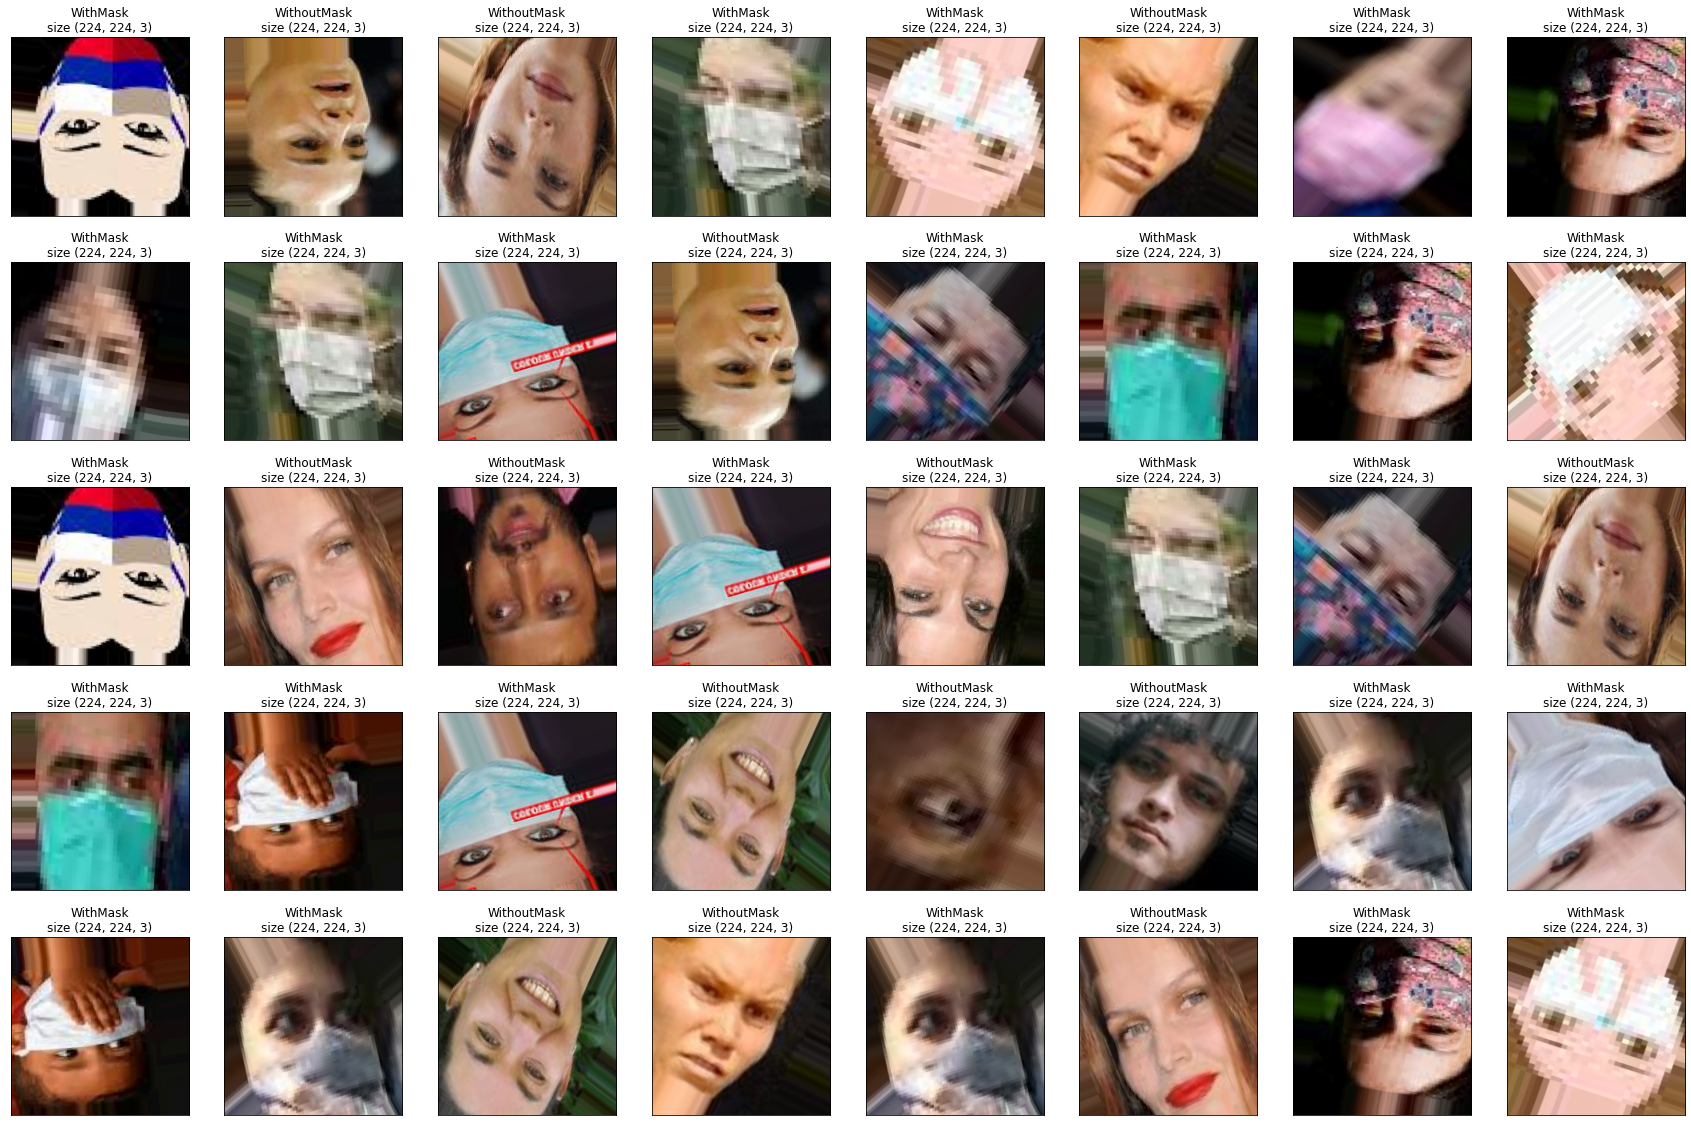

In [7]:

#get data for generator
train_images=train_generator.__getitem__(0)[0]
train_labels=train_generator.__getitem__(0)[1]
#get the label number
lab=np.argmax(train_labels, axis=1)
#show train generator
image_show(train_images,lab,40)

In [8]:

denenet_model=VGG19(weights="imagenet", include_top=False , input_shape=(image_size,image_size,3) )

    
    
denenet_model.summary()



x=GlobalAveragePooling2D()(denenet_model.output)
x=Dense(1024, activation="relu")(x)


x=Dense(256, activation="relu")(x)

x=Dense(128, activation="relu")(x)

x=Dense(64, activation="relu")(x)

output=Dense(2, activation="softmax")(x)

model=Model(inputs=denenet_model.input, outputs=output)
model.summary()

# #plot model
# from tensorflow.python.keras.utils.vis_utils import plot_model
# plot_model(model, show_shapes=True, show_layer_names=True , to_file="model.png")



80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
#callbacks
callbacks_denseNet=[
    tf.keras.callbacks.EarlyStopping(monitor="val_loss" , patience=5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint("faceMakModel.h5" , save_best_only=True, verbose=1),
#  lr_rate
    ]



#training Densenet Model

# check t batch size is 32
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001 , epsilon=1e-07) , 
              loss=tf.keras.losses.binary_crossentropy , 
              metrics=["accuracy"])

DenseNet_history=model.fit(
          train_generator  , 
          epochs=5   , 
#           steps_per_epoch=x_train.shape[0]/batch_size ,
          validation_data=val_generator,
          verbose=1 ,
          callbacks=callbacks_denseNet
               )


Epoch 1/5
 48/313 [===>..........................] - ETA: 2:45 - loss: 0.5400 - accuracy: 0.7424

In [ ]:
print("- the Accuracy and Loss for Vgg16 Model With 10 Epochs")
plt.figure(figsize=(40,20))
# summarize history for accuracy 
plt.subplot(5,5,1)
plt.plot(DenseNet_history.history['accuracy'])
plt.plot(DenseNet_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')



# summarize history for loss
plt.subplot(5,5,2)
plt.plot(DenseNet_history.history['loss'])
plt.plot(DenseNet_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','loss'], loc='upper left')
plt.show()

In [ ]:
#evaluate 
print('evaluate')
model.evaluate(train_generator ), model.evaluate( val_generator), model.evaluate( test_generator)

In [ ]:
#to download output files from kaggle
import os
os.chdir(r'../working')
from IPython.display import FileLink
FileLink(r'./faceMakModel.h5')